CoD & LCoD Implementation
===================

import needed packages

In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from torch.linalg import eigvalsh 
import numpy as np
import matplotlib.pyplot as plt

Fixing the Seed of the code and datatype

In [2]:
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

Creating Dataset and plotting

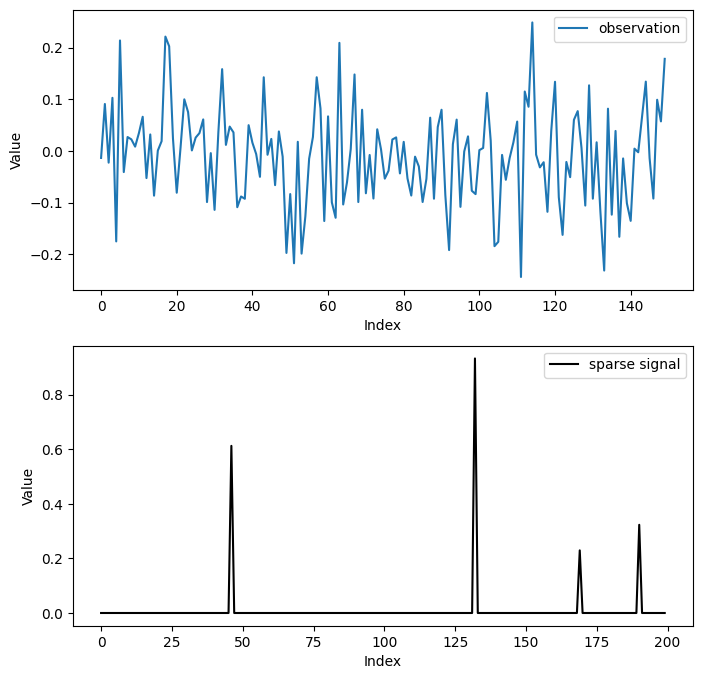

In [3]:
class SimulatedData(Data.Dataset): #Creates tuple (x, H, s) for each sample
    def __init__(self, x, H, s):
        self.x = x
        self.s = s
        self.H = H

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx, :]
        H = self.H
        s = self.s[idx, :]
        return x, H, s

def create_data_set(H, n, m, k, N=1000, batch_size=512, signal_dev=0.5, noise_dev=0.01): #function to create dataset
    # Initialization
    x = torch.zeros(N, n)
    s = torch.zeros(N, m)

    # Create signals
    for i in range(N):
        # Create a k-sparsed signal s
        index_k = np.random.choice(m, k, replace=False)
        peaks = signal_dev * np.random.randn(k)

        s[i, index_k] = torch.from_numpy(peaks).to(s)

        # X = Hs+w
        x[i, :] = H @ s[i, :] + noise_dev * torch.randn(n)

    simulated = SimulatedData(x=x, H=H, s=s)
    data_loader = Data.DataLoader(dataset=simulated, batch_size=batch_size, shuffle=True)
    return data_loader

N = 1000 # number of samples
n = 150 # dim(x)
m = 200 # dim(s)
k = 4 # k-sparse signal

# Measurement matrix
H = torch.randn(n, m)
H /= torch.norm(H, dim=0)

# Generate datasets
train_loader = create_data_set(H, n=n, m=m, k=k, N=N)
test_loader = create_data_set(H, n=n, m=m, k=k, N=N, batch_size=N)

x_exm, _, s_exm =test_loader.dataset.__getitem__(5)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'sparse signal', color='k')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

Training Function

In [4]:
def train(model, train_loader, valid_loader, num_epochs=50):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))
    # Main loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(train_loader):
            s_hat, _ = model.forward(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # validation
        model.eval()
        test_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(valid_loader):
            # b_x, b_H, b_x = b_x.cuda(), b_H.cuda(), b_s.cuda()
            s_hat, _ = model.forward(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)
        # Print
        if epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

CoD implementation

In [5]:
def cod(x, H, b_s, alpha=0.05, max_itr=300):
    # Coordinate Descent Algorithm
    m = H.shape[1]
    z = torch.zeros((m, 1), dtype=torch.float64)
    loss_vs_iter = torch.zeros(max_itr, dtype=torch.float64)
    B = H.T @ x  # Initial coefficients
    S = torch.eye(m, dtype=torch.float64) - H.T @ H  # Residual matrix
    for idx in range(max_itr):
        z_bar = torch.sign(B) * torch.maximum(torch.abs(B) - alpha, torch.zeros_like(B))
        k = torch.argmax(torch.abs(z - z_bar))
        delta = z_bar[k, 0] - z[k, 0]
        B = B + S[:, [k]] * delta
        z[k, 0] = z_bar[k, 0]
        loss_vs_iter[idx] = F.mse_loss(z, b_s, reduction="sum").data.item()
    
    return loss_vs_iter

def cod_apply(test_loader, H, alpha=0.05, max_itr=100):
    """Apply CoD to the test set."""
    loss_vs_iter = np.zeros((len(test_loader.dataset), max_itr))
    sample_idx = 0
    for b_x, _, b_s in test_loader:  # b_x: (batch_size, n), b_s: (batch_size, m)
        batch_size = b_x.shape[0]
        for i in range(batch_size):
            loss_vs_iter[sample_idx, :] = cod(b_x[i].unsqueeze(1), H, b_s[i].unsqueeze(1),
                                              alpha=alpha, max_itr=max_itr)
            sample_idx += 1
    return loss_vs_iter.mean(axis=0)


cod_mse_vs_iter = cod_apply(test_loader, H, alpha=0.05, max_itr=100)
#print("CoD MSE vs Iteration:", cod_mse_vs_iter)

LCoD Class

In [6]:
class LearnedCoD(nn.Module):
    def __init__(self, H, T=10, learn_alpha=True):
        super(LearnedCoD, self).__init__()
        self.T = T
        self.H = H
        self.m = H.shape[1]

        # Fixed matrices (you can make them learnable if needed)
        self.B_mat = nn.Parameter(H.T.clone(), requires_grad=False)
        self.S_mat = nn.Parameter(torch.eye(self.m, dtype=torch.float64) - H.T @ H, requires_grad=False)

        # Learnable thresholds
        if learn_alpha:
            self.alpha_list = nn.ParameterList([nn.Parameter(torch.tensor(0.05, dtype=torch.float64)) for _ in range(T)])
        else:
            self.alpha_list = [torch.tensor(0.05, dtype=torch.float64) for _ in range(T)]

    def soft_threshold(self, B, alpha):
        return torch.sign(B) * torch.maximum(torch.abs(B) - alpha, torch.zeros_like(B))

    def forward(self, x, s_gt=None):
        if x.dim() == 2 and x.shape[1] == self.H.shape[0]:
            batch_size = x.shape[0]
            z_out = []
            mse_list = []

            for i in range(batch_size):
                z_i, mse_i = self.forward(x[i].unsqueeze(1), s_gt[i].unsqueeze(1) if s_gt is not None else None)
                z_out.append(z_i.squeeze(1))  # (m, 1) -> (m,)
                if s_gt is not None:
                    mse_list.append(mse_i)

            z_out = torch.stack(z_out, dim=0)  # shape: (batch_size, m)
            if s_gt is not None:
                mse_avg = torch.stack(mse_list, dim=0).mean(dim=0)
                return z_out, mse_avg
            else:
                return z_out, None

    # Single sample mode (x shape = [n, 1])
        B = self.B_mat @ x  # shape: (m, 1)
        z = torch.zeros((self.m, 1), dtype=torch.float64, device=x.device)
        mse_vs_iter = []

        for t in range(self.T):
            z_bar = self.soft_threshold(B, self.alpha_list[t])
            k = torch.argmax(torch.abs(z - z_bar))
            delta = z_bar[k, 0] - z[k, 0]
            B = B + self.S_mat[:, [k]] * delta
            z[k, 0] = z_bar[k, 0]

            if s_gt is not None:
                mse = F.mse_loss(z.detach(), s_gt.detach(), reduction="sum").item()
                mse_vs_iter.append(mse)

        if s_gt is not None:
            return z, torch.tensor(mse_vs_iter, dtype=torch.float64)
        else:
            return z, None


LCoD implementation(Untrained)

In [7]:
def lcod_untrained_apply(test_loader, T, H):
    #n = H.shape[0]
    #m = H.shape[1]
    # Create LCOD model with default untrained parameters
    lcod_untrained = LearnedCoD(H=H, T=T, learn_alpha=False)
    x = test_loader.dataset.x
    s_gt = test_loader.dataset.s
    mse = torch.zeros(T, dtype=torch.float64)
    for i in range(len(x)):
        x_i = x[i].unsqueeze(1)  # Shape: (n, 1)
        s_gt_i = s_gt[i].unsqueeze(1)  # Shape: (m, 1)
        #x_i = x[i].unsqueeze(1)  # Shape: (n, 1)
        _, mse_curve = lcod_untrained(x_i, s_gt=s_gt_i)
        mse += mse_curve

    mse_vs_iter = mse / len(x)
    return mse_vs_iter.numpy()

T = 100  # Number of iterations for LCOD
lcod_untrained_mse_vs_iter = lcod_untrained_apply(test_loader, T=T, H=H)


plot just CoD 

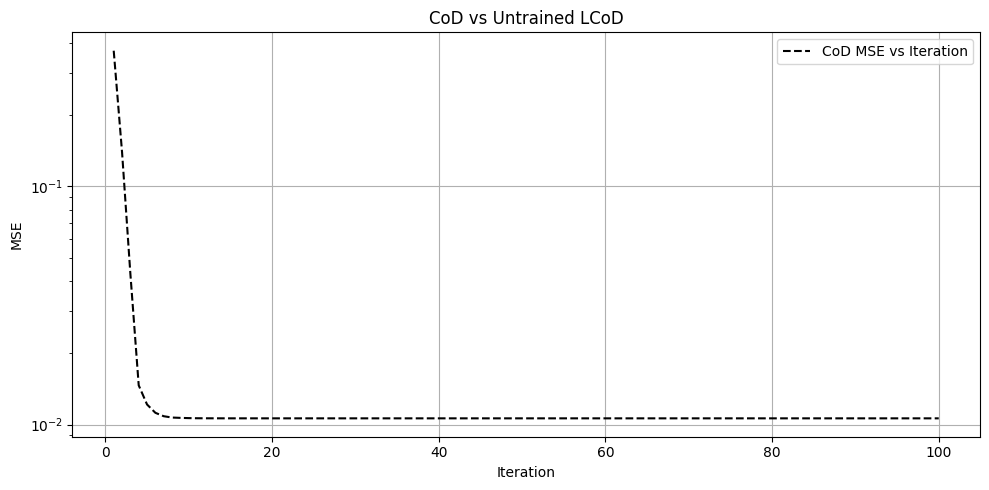

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, T + 1), cod_mse_vs_iter, label='CoD MSE vs Iteration', color="black", ls ='--')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.yscale('log')
plt.title("CoD vs Untrained LCoD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plot CoD and untrained LCoD

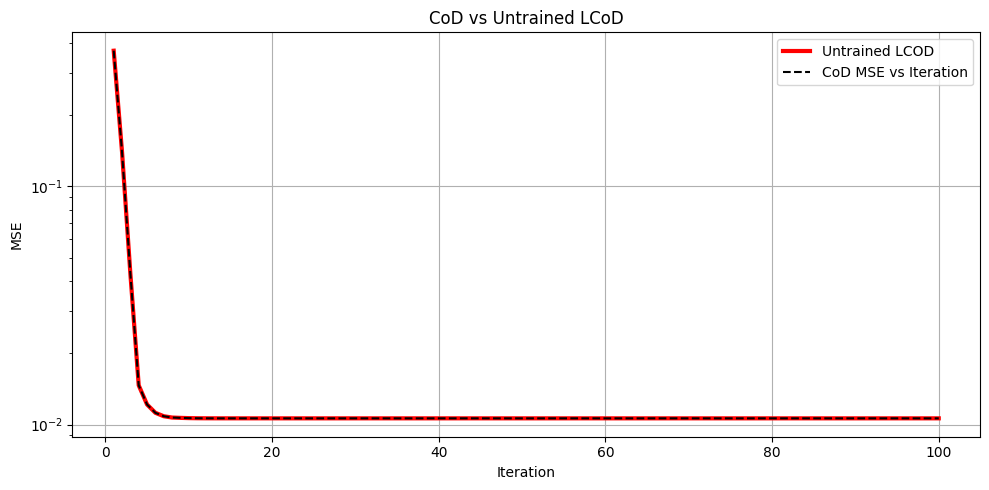

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, T + 1), lcod_untrained_mse_vs_iter, label="Untrained LCOD", color="red", lw=3)
plt.plot(range(1, T + 1), cod_mse_vs_iter, label='CoD MSE vs Iteration', color="black", ls ='--')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.yscale('log')
plt.title("CoD vs Untrained LCoD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

CoD Implementation(Trained)

In [10]:
def lcod_apply(train_loader, test_loader, T, H, num_epochs=50):
    model = LearnedCoD(H=H, T=T, learn_alpha=True)
    
    train(model, train_loader, test_loader, num_epochs=num_epochs)

    x = test_loader.dataset.x
    s_gt = test_loader.dataset.s
    mse = torch.zeros(T, dtype=torch.float64)

    for i in range(len(x)):
        _, mse_curve = model(x[i].unsqueeze(1), s_gt=s_gt[i].unsqueeze(1))
        mse += mse_curve

    mse_vs_iter = mse / len(x)
    return mse_vs_iter.numpy()

T_t = 5  # Number of iterations for LCOD
lcod_mse_vs_iter = lcod_apply(train_loader, test_loader, T=T_t, H=H, num_epochs=50)
print(lcod_mse_vs_iter)

Epoch 0, Train loss 0.01093610, Validation loss 0.00960207
Epoch 10, Train loss 0.00186862, Validation loss 0.00178639
Epoch 20, Train loss 0.00171545, Validation loss 0.00160310
Epoch 30, Train loss 0.00165868, Validation loss 0.00156117
Epoch 40, Train loss 0.00163824, Validation loss 0.00155602
[0.36928298 0.13396863 0.03431672 0.00383634 0.00156113]


plot CoD and LCoD(Trained)

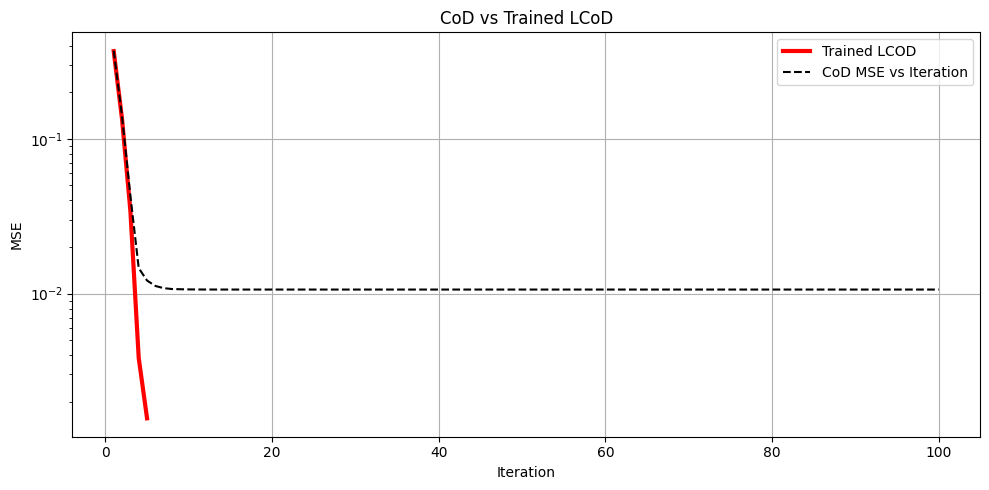

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, T_t + 1), lcod_mse_vs_iter, label="Trained LCOD", color="red", lw=3)
plt.plot(range(1, T + 1), cod_mse_vs_iter, label='CoD MSE vs Iteration', color="black", ls ='--')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.yscale('log')
plt.title("CoD vs Trained LCoD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()